In [29]:
from src.PyTorch.HiggsDataset import HiggsDataset
from torch.utils.data import DataLoader
import keras
from src.Keras.PointCloudLayer import PointNetLayer, ChannelWiseGlobalAveragePooling

In [30]:
# Creating the trainning, validation and test set
higges_trainning = HiggsDataset("../Data/HiggsTrainning.csv", "cpu")
higgs_validation = HiggsDataset("../Data/HiggsValidation.csv", "cpu")
higgs_test = HiggsDataset("../Data/HiggsTest.csv", "cpu")

# Exctracting the data from the torch tensors and converting to numpy arrays
data_loader_trainning = DataLoader(higges_trainning, batch_size=len(higges_trainning))
data_loader_validation = DataLoader(higgs_validation, batch_size=len(higgs_validation))
data_loader_test = DataLoader(higgs_test, batch_size=len(higgs_test))

torch_to_numpy = lambda torch_data: torch_data.numpy()
X_train, y_train = map(torch_to_numpy, next(iter(data_loader_trainning)))
X_val, y_val = map(torch_to_numpy, next(iter(data_loader_validation)))
X_test, y_test = map(torch_to_numpy, next(iter(data_loader_test)))

In [31]:
# just including one layer
mlp = keras.Sequential([
    keras.layers.InputLayer(shape=[7]),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu')
])

mlp_2 = keras.Sequential([
    keras.layers.InputLayer(shape=[32]),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu')
])

model = keras.Sequential([
    keras.layers.InputLayer(shape=[6, 7]),
    PointNetLayer(mlp),
    PointNetLayer(mlp_2),
    ChannelWiseGlobalAveragePooling(),
    keras.layers.Dense(64),
    keras.layers.Dropout(rate=0.1),
    keras.layers.ReLU(),
    keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ point_net_layer_6               │ (None, 6, 32)          │         2,368 │
│ (PointNetLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ point_net_layer_7               │ (None, 6, 64)          │        10,432 │
│ (PointNetLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ channel_wise_global_average_po… │ (None, 64)             │             0 │
│ (ChannelWiseGlobalAveragePooli… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,090 (66.76 KB)

 Trainable params: 17,090 (66.76 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(optimizer='adam', loss='crossentropy', metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 2s 705us/step - accuracy: 0.5376 - loss: 0.6886 - val_accuracy: 0.5594 - val_loss: 0.6725
Epoch 2/100
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.5573 - loss: 0.6758 - val_accuracy: 0.5644 - val_loss: 0.6794
Epoch 3/100
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step - accuracy: 0.5588 - loss: 0.6749 - val_accuracy: 0.5648 - val_loss: 0.6715
Epoch 4/100
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step - accuracy: 0.5649 - loss: 0.6730 - val_accuracy: 0.5747 - val_loss: 0.6695
Epoch 5/100
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step - accuracy: 0.5744 - loss: 0.6713 - val_accuracy: 0.5839 - val_loss: 0.6656
Epoch 6/100
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step - accuracy: 0.5779 - loss: 0.6680 - val_accuracy: 0.5897 - val_loss: 0.6621
Epoch 7/100
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - accuracy: 0.5859 - loss: 0.6656 - val_accuracy: 0.5866 - val_loss: 0.6670
Epoch 8/100
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - accuracy: 

In [33]:
# perfoming the prediction
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 298us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


In [34]:
from sklearn.metrics import recall_score, precision_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [35]:
print("Trainnig set:")
print(f"Recall for Top tagging: {recall_score(y_train[:, 0], y_train_pred[:, 0] >= 0.5):.4f}")
print(f"Precision for Top tagging: {precision_score(y_train[:, 0], y_train_pred[:, 0] > 0.5):.4f}")
print("Confusion Matrix")
print(confusion_matrix(y_train[:, 0], y_train_pred[:, 0] > 0.5, labels=[0, 1]))

Trainnig set:
Recall for Top tagging: 0.5474
Precision for Top tagging: 0.6598
Confusion Matrix
[[26853  9058]
 [14525 17564]]


In [36]:
print("Test set:")
print(f"Recall for Top tagging: {recall_score(y_val[:, 0], y_val_pred[:, 0] > 0.5):.2f}")
print(f"Precision for Top tagging: {precision_score(y_val[:, 0], y_val_pred[:, 0] > 0.5):.2f}")
print("Confusion Matrix")
print(confusion_matrix(y_val[:, 0], y_val_pred[:, 0] > 0.5, labels=[0, 1]))

Test set:
Recall for Top tagging: 0.54
Precision for Top tagging: 0.64
Confusion Matrix
[[4625 1696]
 [2635 3044]]


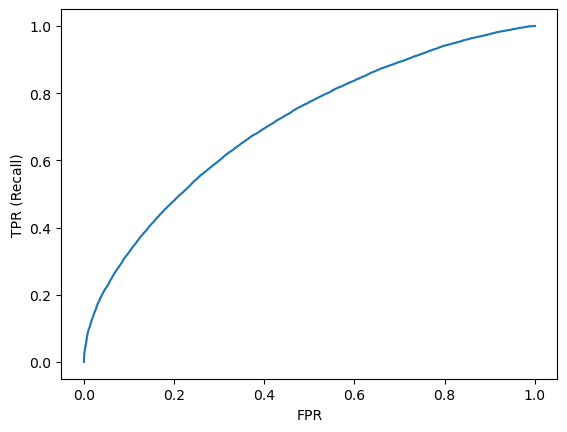

AUC: 0.7086


In [37]:
# roc curve for top tagging 
fpr, tpr, thresholds = roc_curve(y_train[:, 0], y_train_pred[:, 0])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.show()
print(f"AUC: {auc(fpr, tpr):.4f}")